In [1]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.metrics import mean_absolute_error, mean_squared_error
import time
import lightgbm as lgb
from xgboost import XGBRegressor

# **DATA**

In [2]:
df = pd.read_csv('../input/interview-data-science/Data_Scientist_Interview_Task.csv')

In [3]:
df.head()

,Claim Number,date_of_loss,Notifier,Loss_code,Loss_description,Notification_period,Inception_to_loss,Location_of_incident,Weather_conditions,Vehicle_mobile,...,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Incurred,Capped Incurred,Unnamed: 46
0,1,2003-04-15,PH,LD003,Head on collision,22,13,Main Road,NORMAL,Y,...,-,-,-,-,-,-,-,£-,£-,NaN
1,2,2003-04-20,CNF,LD003,Head on collision,1,9,Main Road,WET,Y,...,-,-,1,-,-,-,-,"£2,801","£2,801",NaN
2,3,2003-04-24,CNF,LD003,Head on collision,5,17,Main Road,WET,Y,...,-,-,-,-,-,-,-,"£1,221","£1,221",NaN
3,4,2003-05-13,CNF,LD003,Head on collision,1,23,Main Road,N/K,Y,...,-,-,-,-,-,1,-,"£3,530","£3,530",NaN
4,5,2003-06-11,CNF,LD003,Head on collision,1,48,Other,N/K,N,...,-,-,-,-,-,-,-,"£3,156","£3,156",NaN


In [4]:
df.shape

(7691, 47)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7691 entries, 0 to 7690
Data columns (total 47 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Claim Number                    7691 non-null   int64  
 1   date_of_loss                    7691 non-null   object 
 2   Notifier                        7691 non-null   object 
 3   Loss_code                       7691 non-null   object 
 4   Loss_description                7691 non-null   object 
 5   Notification_period             7691 non-null   int64  
 6   Inception_to_loss               7691 non-null   int64  
 7   Location_of_incident            7691 non-null   object 
 8   Weather_conditions              7346 non-null   object 
 9   Vehicle_mobile                  7691 non-null   object 
 10  Time_hour                       7691 non-null   int64  
 11  Main_driver                     7691 non-null   object 
 12  PH_considered_TP_at_fault       76

In [6]:
# checking null values for all data

df.isnull().sum() /len(df)*100

Claim Number                        0.000000
date_of_loss                        0.000000
Notifier                            0.000000
Loss_code                           0.000000
Loss_description                    0.000000
Notification_period                 0.000000
Inception_to_loss                   0.000000
Location_of_incident                0.000000
Weather_conditions                  4.485763
Vehicle_mobile                      0.000000
Time_hour                           0.000000
Main_driver                         0.000000
PH_considered_TP_at_fault           0.000000
 Vechile_registration_present       0.000000
 Incident_details_present           0.000000
 Injury_details_present             0.000000
 TP_type_insd_pass_back             0.000000
 TP_type_insd_pass_front            0.000000
 TP_type_driver                     0.000000
 TP_type_pass_back                  0.000000
 TP_type_pass_front                 0.000000
 TP_type_bike                       0.000000
 TP_type_c

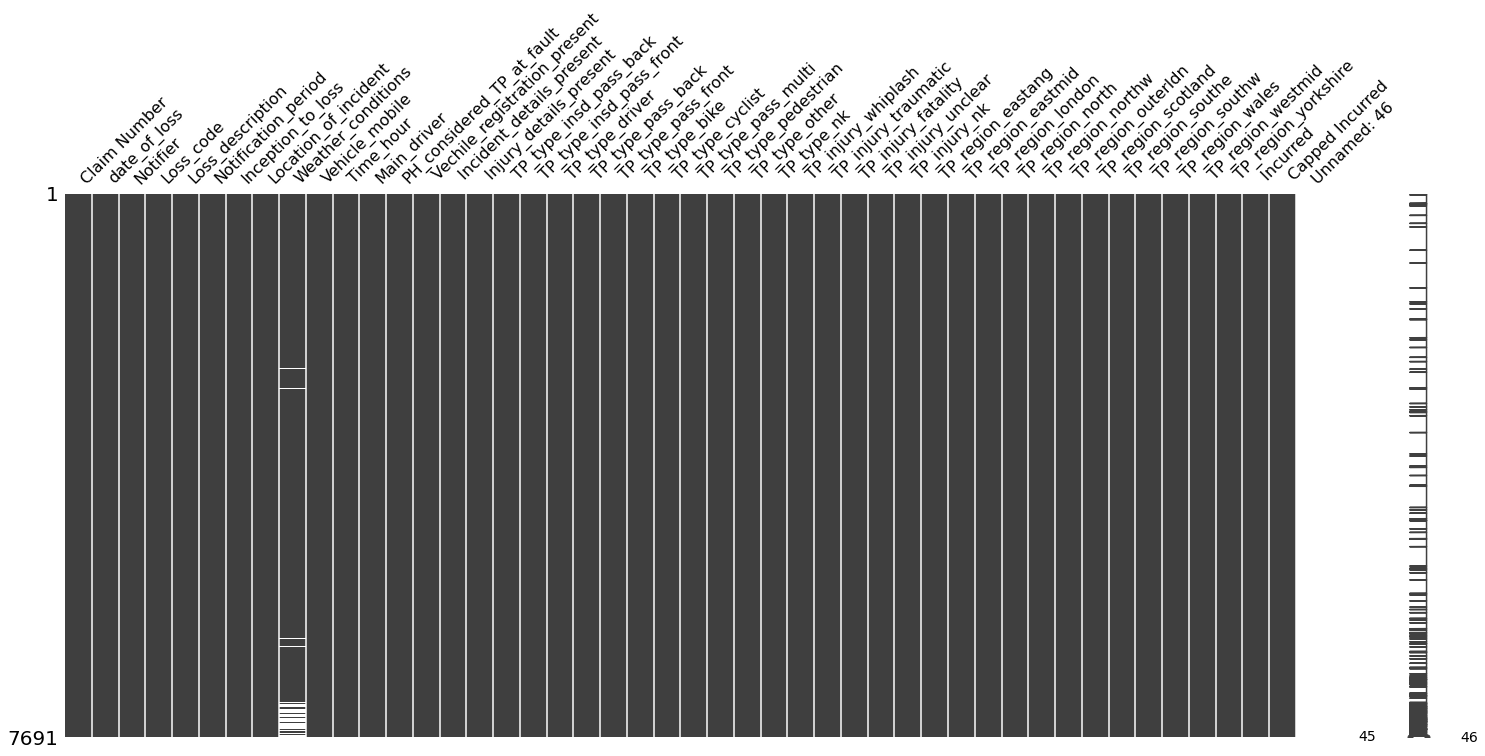

In [7]:
msno.matrix(df)
plt.show()

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Claim Number,7691.0,3846.000000,2220.344793,1.0,1923.5,3846.0,5768.5,7691.0
Notification_period,7691.0,7.163438,39.138209,-18.0,0.0,1.0,2.0,1042.0
Inception_to_loss,7691.0,166.854505,104.452906,0.0,75.0,161.0,253.0,365.0
Time_hour,7691.0,12.729684,5.107136,0.0,9.0,13.0,17.0,23.0
Unnamed: 46,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# **PREPARING DATA**


### Deleting gaps in column names


In [9]:
df.columns[20]

' TP_type_pass_front '

In [10]:
df.columns = df.columns.str.strip()

In [11]:
df.columns[20]

'TP_type_pass_front'

### Dropping columns

In [12]:
df.drop(['Claim Number','Unnamed: 46', 'Capped Incurred'], inplace  = True, axis = 1)

In [13]:
df['Incurred'].value_counts()

 £-          1754
 £23           54
 £24           28
 £86           22
 £19           18
             ... 
 £2,695         1
 £16,255        1
 £3,489         1
 £841           1
 £30,072        1
Name: Incurred, Length: 4327, dtype: int64

### **Deleting gaps in dependent value**


In [14]:
df['Incurred'][1]

' £2,801 '

In [15]:
df['Incurred'] = df['Incurred'].apply(lambda x: x.strip())

### **Deleting symbol (£) in dependent values**


In [16]:
df['Incurred'][1]

'£2,801'

In [17]:
df['Incurred'] = df['Incurred'].apply(lambda x :str(x).split('£')[1])

In [18]:
df['Incurred'][1]

'2,801'

### **Converting dependent variable to float**

In [19]:
df['Incurred'] 

0            -
1        2,801
2        1,221
3        3,530
4        3,156
         ...  
7686       703
7687    42,981
7688     5,175
7689    30,072
7690     1,925
Name: Incurred, Length: 7691, dtype: object

In [20]:
df['Incurred'] = df['Incurred'].apply(lambda x: x.replace(',', ''))

In [21]:
df['Incurred']  = pd.to_numeric(df['Incurred'], errors='coerce')

In [22]:
df['Incurred'] 

0           NaN
1        2801.0
2        1221.0
3        3530.0
4        3156.0
         ...   
7686      703.0
7687    42981.0
7688     5175.0
7689    30072.0
7690     1925.0
Name: Incurred, Length: 7691, dtype: float64

In [23]:
df['Incurred'].isnull().sum()

1754

### **Deleting outlier values**

In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Notification_period,7691.0,7.163438,39.138209,-18.0,0.0,1.0,2.0,1042.0
Inception_to_loss,7691.0,166.854505,104.452906,0.0,75.0,161.0,253.0,365.0
Time_hour,7691.0,12.729684,5.107136,0.0,9.0,13.0,17.0,23.0
Incurred,5937.0,12219.117399,56438.896057,0.0,640.0,2598.0,9767.0,1951894.0


In [25]:
def outlier_thresholds(dataframe, col_name):
    quartile1 = dataframe[col_name].quantile(0.25)
    quartile3 = dataframe[col_name].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

outlier_thresholds(df, "Incurred")

low, up = outlier_thresholds(df, "Incurred")

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers


df = remove_outlier(df, "Incurred")


In [26]:

df.describe().T

,count,mean,std,min,25%,50%,75%,max
Notification_period,7087.0,7.310569,39.877341,-18.0,0.0,1.0,2.0,1042.0
Inception_to_loss,7087.0,166.884436,104.310992,0.0,75.0,160.0,253.0,365.0
Time_hour,7087.0,12.671229,5.055855,0.0,9.0,13.0,17.0,23.0
Incurred,5333.0,4451.696231,5540.513767,0.0,508.0,2038.0,6220.0,23383.0


In [27]:
df.dropna(subset=['Incurred'], inplace=True)
#df["Incurred"] = df["Incurred"].fillna(df["Incurred"].mean())


### **Date format for date_of_loss**

In [28]:
df['date_of_loss'] = pd.to_datetime(df['date_of_loss'])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5333 entries, 1 to 7690
Data columns (total 44 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date_of_loss                  5333 non-null   datetime64[ns]
 1   Notifier                      5333 non-null   object        
 2   Loss_code                     5333 non-null   object        
 3   Loss_description              5333 non-null   object        
 4   Notification_period           5333 non-null   int64         
 5   Inception_to_loss             5333 non-null   int64         
 6   Location_of_incident          5333 non-null   object        
 7   Weather_conditions            5093 non-null   object        
 8   Vehicle_mobile                5333 non-null   object        
 9   Time_hour                     5333 non-null   int64         
 10  Main_driver                   5333 non-null   object        
 11  PH_considered_TP_at_fault     

### **Categorical variables**

In [30]:
subset = df.columns.difference(['date_of_loss','Notification_period', 'Inception_to_loss','Time_hour', 'Incurred'])
subset

Index(['Incident_details_present', 'Injury_details_present',
       'Location_of_incident', 'Loss_code', 'Loss_description', 'Main_driver',
       'Notifier', 'PH_considered_TP_at_fault', 'TP_injury_fatality',
       'TP_injury_nk', 'TP_injury_traumatic', 'TP_injury_unclear',
       'TP_injury_whiplash', 'TP_region_eastang', 'TP_region_eastmid',
       'TP_region_london', 'TP_region_north', 'TP_region_northw',
       'TP_region_outerldn', 'TP_region_scotland', 'TP_region_southe',
       'TP_region_southw', 'TP_region_wales', 'TP_region_westmid',
       'TP_region_yorkshire', 'TP_type_bike', 'TP_type_cyclist',
       'TP_type_driver', 'TP_type_insd_pass_back', 'TP_type_insd_pass_front',
       'TP_type_nk', 'TP_type_other', 'TP_type_pass_back',
       'TP_type_pass_front', 'TP_type_pass_multi', 'TP_type_pedestrian',
       'Vechile_registration_present', 'Vehicle_mobile', 'Weather_conditions'],
      dtype='object')

 
###############################################################
 
###############################################################
       Incident_details_present      Ratio
 1                         4303  80.686293
 -                         1030  19.313707
 
 


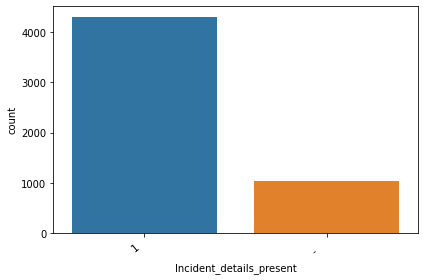

 
###############################################################
 
###############################################################
       Injury_details_present      Ratio
 -                       4108  77.029814
 1                       1225  22.970186
 
 


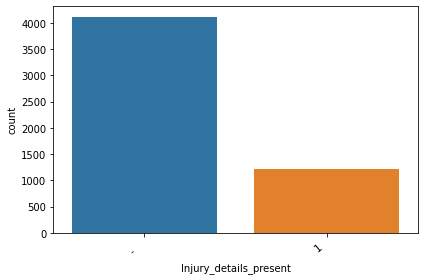

 
###############################################################
 
###############################################################
                Location_of_incident      Ratio
Minor Road                      3010  56.441028
Main Road                       1819  34.108382
Car Park                         161   3.018939
n/k                              133   2.493906
Home Address                      81   1.518845
Other                             77   1.443840
Not Applicable                    37   0.693793
Motorway                          15   0.281268
 
 


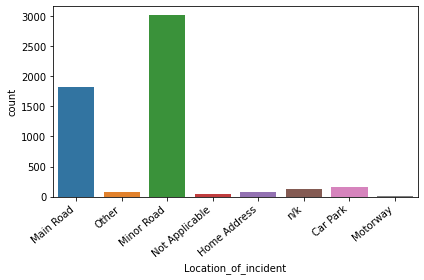

 
###############################################################
 
###############################################################
       Loss_code  Ratio
LD003       5333  100.0
 
 


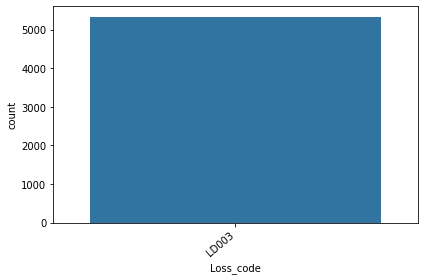

 
###############################################################
 
###############################################################
                   Loss_description  Ratio
Head on collision              5333  100.0
 
 


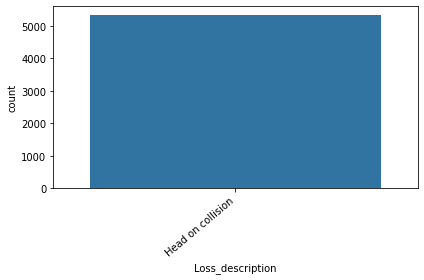

 
###############################################################
 
###############################################################
       Main_driver      Ratio
Y             2918  54.715920
Other         2140  40.127508
N              275   5.156572
 
 


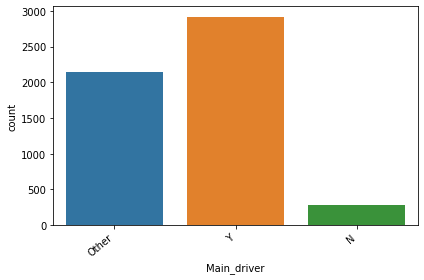

 
###############################################################
 
###############################################################
             Notifier      Ratio
PH               2569  48.171761
Other            2258  42.340146
CNF               197   3.693981
TP                195   3.656479
NamedDriver       114   2.137634
 
 


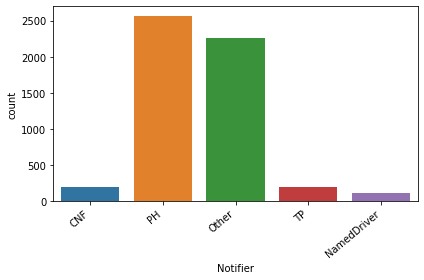

 
###############################################################
 
###############################################################
     PH_considered_TP_at_fault      Ratio
N                         3212  60.228764
n/k                       1968  36.902306
Y                          153   2.868929
 
 


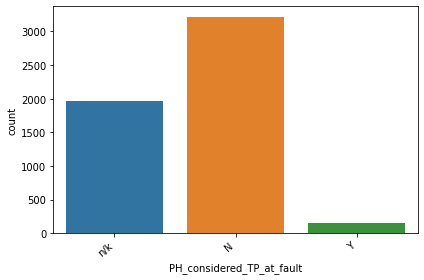

 
###############################################################
 
###############################################################
       TP_injury_fatality      Ratio
 -                   5320  99.756235
 1                     13   0.243765
 
 


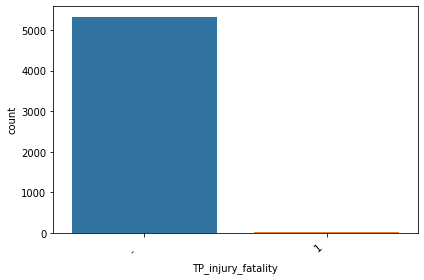

 
###############################################################
 
###############################################################
       TP_injury_nk      Ratio
 -             2625  49.221826
 1             2458  46.090381
 2              199   3.731483
 3               33   0.618789
 4               15   0.281268
 5                2   0.037502
 6                1   0.018751
 
 


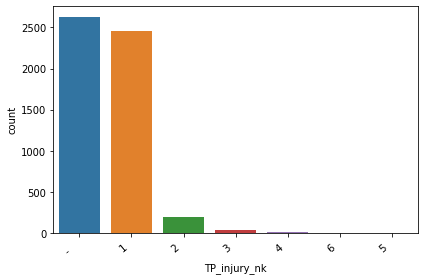

 
###############################################################
 
###############################################################
       TP_injury_traumatic      Ratio
 -                    5070  95.068442
 1                     240   4.500281
 2                      20   0.375023
 3                       2   0.037502
 4                       1   0.018751
 
 


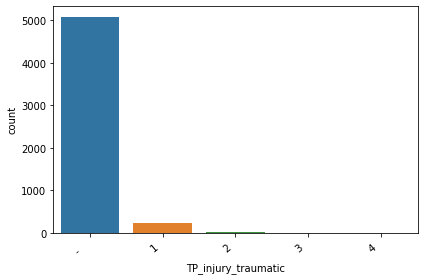

 
###############################################################
 
###############################################################
       TP_injury_unclear      Ratio
 1                  4006  75.117195
 -                   930  17.438590
 2                   342   6.412901
 3                    45   0.843803
 4                     6   0.112507
 5                     2   0.037502
 7                     1   0.018751
 6                     1   0.018751
 
 


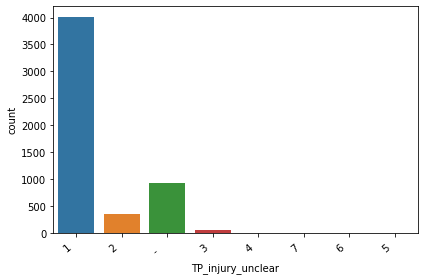

 
###############################################################
 
###############################################################
       TP_injury_whiplash      Ratio
 -                   4363  81.811363
 1                    765  14.344647
 2                    157   2.943934
 3                     36   0.675042
 4                      8   0.150009
 5                      4   0.075005
 
 


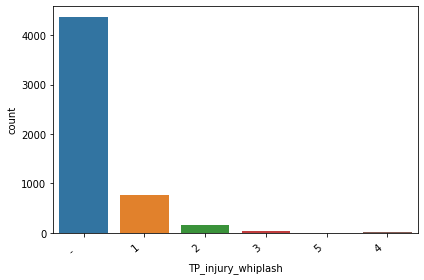

 
###############################################################
 
###############################################################
       TP_region_eastang      Ratio
 -                  5170  96.943559
 1                   144   2.700169
 2                    11   0.206263
 3                     8   0.150009
 
 


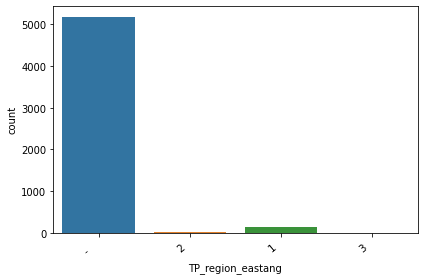

 
###############################################################
 
###############################################################
       TP_region_eastmid      Ratio
 -                  5112  95.855991
 1                   182   3.412713
 2                    31   0.581286
 3                     4   0.075005
 6                     2   0.037502
 4                     2   0.037502
 
 


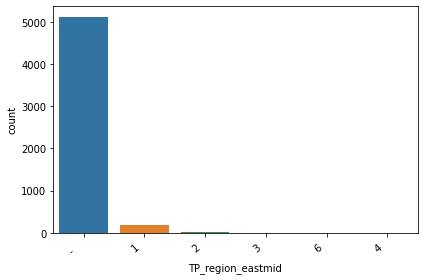

 
###############################################################
 
###############################################################
       TP_region_london      Ratio
 -                 5243  98.312395
 1                   78   1.462591
 2                   10   0.187512
 3                    1   0.018751
 5                    1   0.018751
 
 


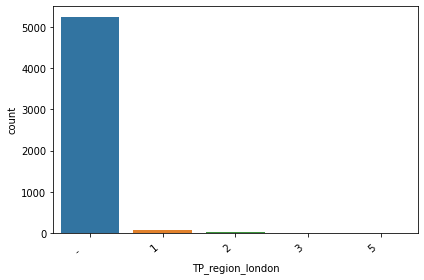

 
###############################################################
 
###############################################################
       TP_region_north      Ratio
 -                5214  97.768611
 1                 100   1.875117
 2                  13   0.243765
 3                   5   0.093756
 4                   1   0.018751
 
 


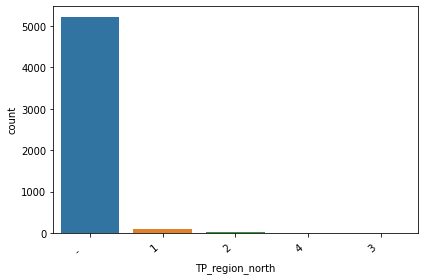

 
###############################################################
 
###############################################################
       TP_region_northw      Ratio
 -                 5084  95.330958
 1                  206   3.862741
 2                   35   0.656291
 3                    7   0.131258
 4                    1   0.018751
 
 


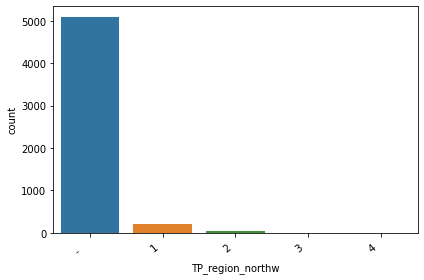

 
###############################################################
 
###############################################################
       TP_region_outerldn      Ratio
 -                   5175  97.037315
 1                    140   2.625164
 2                     16   0.300019
 3                      2   0.037502
 
 


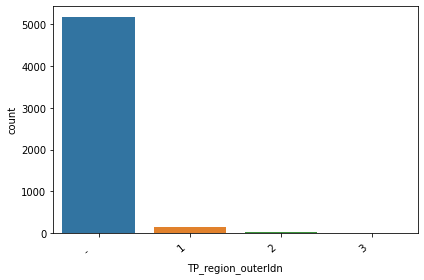

 
###############################################################
 
###############################################################
       TP_region_scotland      Ratio
 -                   5257  98.574911
 1                     67   1.256329
 2                      9   0.168761
 
 


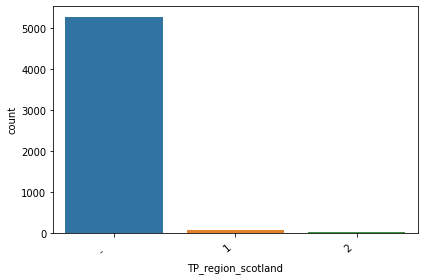

 
###############################################################
 
###############################################################
       TP_region_southe      Ratio
 -                 4786  89.743109
 1                  488   9.150572
 2                   43   0.806300
 3                   12   0.225014
 4                    2   0.037502
 5                    2   0.037502
 
 


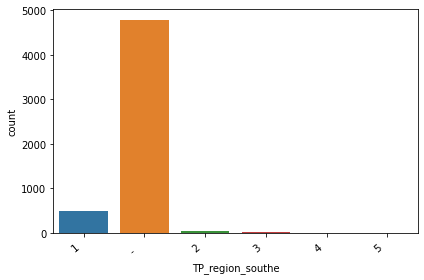

 
###############################################################
 
###############################################################
       TP_region_southw      Ratio
 -                 4878  91.468217
 1                  407   7.631727
 2                   40   0.750047
 3                    8   0.150009
 
 


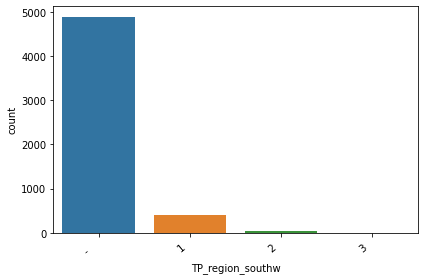

 
###############################################################
 
###############################################################
       TP_region_wales      Ratio
 -                5077  95.199700
 1                 223   4.181511
 2                  24   0.450028
 3                   5   0.093756
 4                   2   0.037502
 7                   1   0.018751
 5                   1   0.018751
 
 


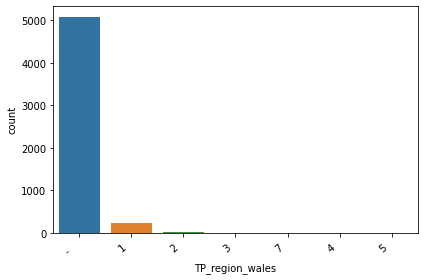

 
###############################################################
 
###############################################################
       TP_region_westmid      Ratio
 -                  5036  94.430902
 1                   250   4.687793
 2                    35   0.656291
 3                     9   0.168761
 4                     2   0.037502
 5                     1   0.018751
 
 


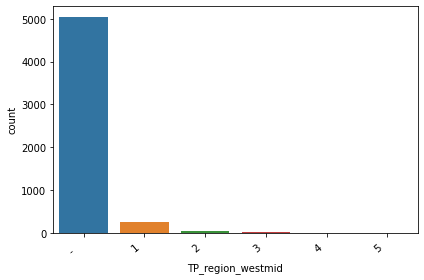

 
###############################################################
 
###############################################################
       TP_region_yorkshire      Ratio
 -                    5019  94.112132
 1                     270   5.062816
 2                      34   0.637540
 3                       7   0.131258
 4                       3   0.056254
 
 


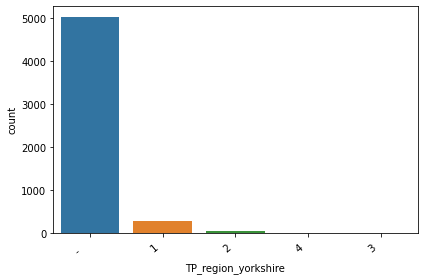

 
###############################################################
 
###############################################################
       TP_type_bike      Ratio
 -             5297  99.324958
 1               36   0.675042
 
 


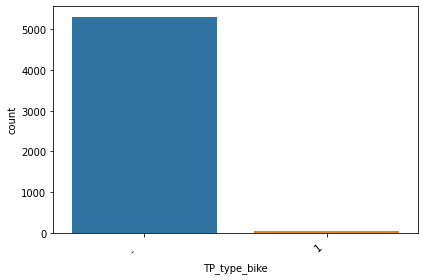

 
###############################################################
 
###############################################################
       TP_type_cyclist      Ratio
 -                5329  99.924995
 1                   4   0.075005
 
 


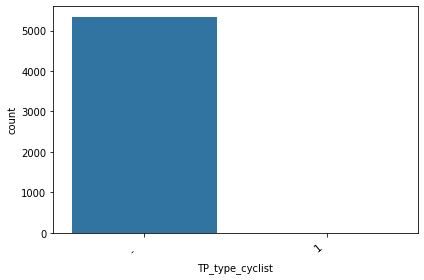

 
###############################################################
 
###############################################################
       TP_type_driver      Ratio
 1               3055  57.284830
 -               2157  40.446278
 2                106   1.987624
 3                 14   0.262516
 4                  1   0.018751
 
 


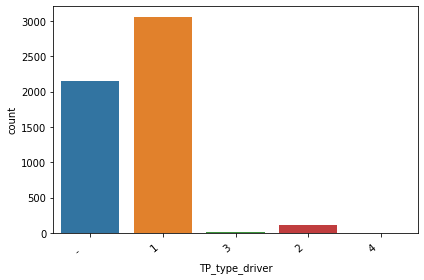

 
###############################################################
 
###############################################################
       TP_type_insd_pass_back      Ratio
 -                       5234  98.143634
 1                         70   1.312582
 2                         25   0.468779
 3                          4   0.075005
 
 


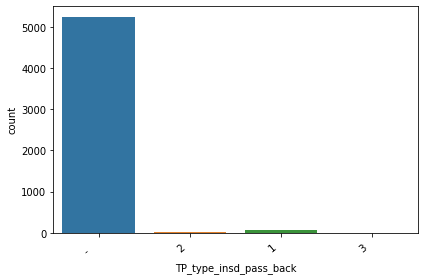

 
###############################################################
 
###############################################################
       TP_type_insd_pass_front  Ratio
 -                        5333  100.0
 
 


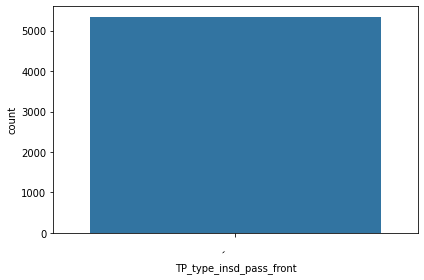

 
###############################################################
 
###############################################################
       TP_type_nk      Ratio
 -           3417  64.072755
 1           1793  33.620851
 2            113   2.118882
 3              8   0.150009
 4              1   0.018751
 6              1   0.018751
 
 


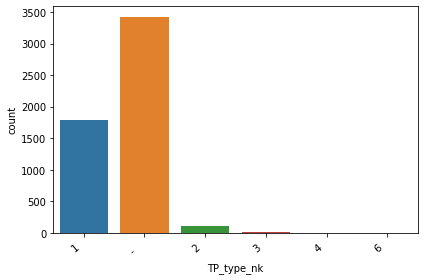

 
###############################################################
 
###############################################################
       TP_type_other      Ratio
 -              5077  95.199700
 1               217   4.069004
 2                26   0.487530
 3                10   0.187512
 4                 3   0.056254
 
 


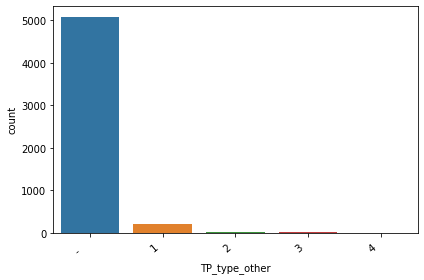

 
###############################################################
 
###############################################################
       TP_type_pass_back      Ratio
 -                  5228  98.031127
 1                    77   1.443840
 2                    23   0.431277
 3                     5   0.093756
 
 


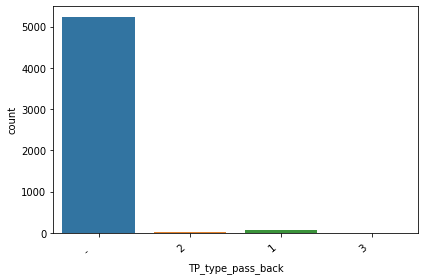

 
###############################################################
 
###############################################################
       TP_type_pass_front      Ratio
 -                   5113  95.874742
 1                    217   4.069004
 2                      3   0.056254
 
 


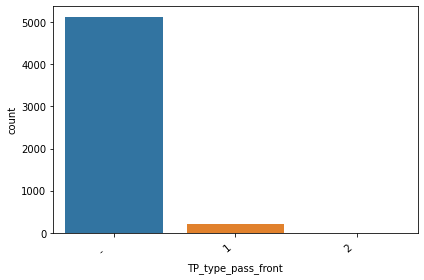

 
###############################################################
 
###############################################################
       TP_type_pass_multi  Ratio
 -                   5333  100.0
 
 


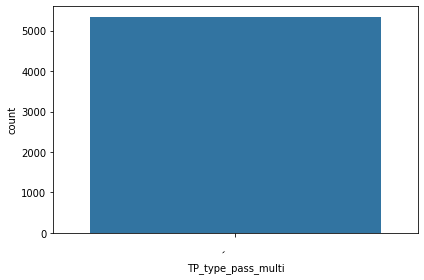

 
###############################################################
 
###############################################################
       TP_type_pedestrian  Ratio
 -                   5333  100.0
 
 


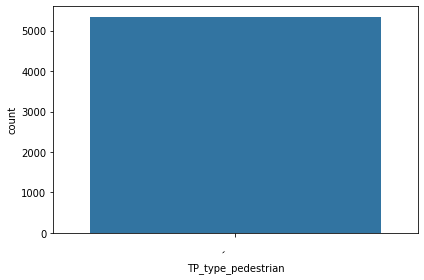

 
###############################################################
 
###############################################################
       Vechile_registration_present      Ratio
 1                             5327  99.887493
 -                                6   0.112507
 
 


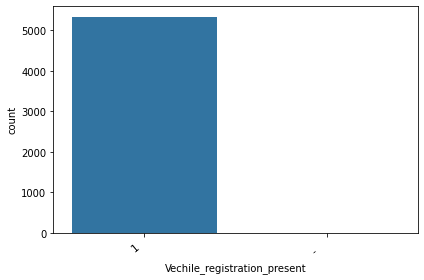

 
###############################################################
 
###############################################################
     Vehicle_mobile      Ratio
Y              2641  49.521845
N              2417  45.321583
n/k             275   5.156572
 
 


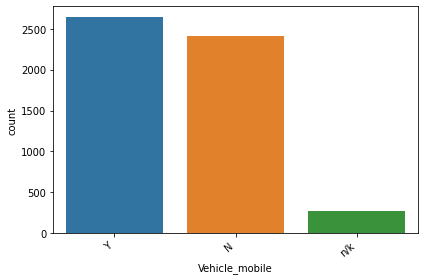

 
###############################################################
 
###############################################################
              Weather_conditions      Ratio
NORMAL                      3064  57.453591
WET                         1418  26.589162
SNOW,ICE,FOG                 338   6.337896
N/K                          273   5.119070
 
 


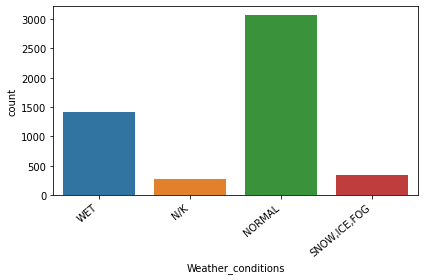

In [31]:
# summary of categorical values and charts

def cat_summary(dataframe, col_name):
    print(' ')
    print('###############################################################')
    print(' ')
    print('###############################################################')
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print(' ')
    print(' ')
    ax = sns.countplot(x=dataframe[col_name], data=dataframe)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()
    

for i in subset:
    cat_summary(df, i)

### **Dropping columns**

In [32]:
df.drop(['Loss_code', 'Loss_description'], inplace = True, axis = True)

In [33]:
subset = df.columns.difference(['date_of_loss','Notification_period', 'Inception_to_loss','Time_hour', 'Incurred'])
subset

Index(['Incident_details_present', 'Injury_details_present',
       'Location_of_incident', 'Main_driver', 'Notifier',
       'PH_considered_TP_at_fault', 'TP_injury_fatality', 'TP_injury_nk',
       'TP_injury_traumatic', 'TP_injury_unclear', 'TP_injury_whiplash',
       'TP_region_eastang', 'TP_region_eastmid', 'TP_region_london',
       'TP_region_north', 'TP_region_northw', 'TP_region_outerldn',
       'TP_region_scotland', 'TP_region_southe', 'TP_region_southw',
       'TP_region_wales', 'TP_region_westmid', 'TP_region_yorkshire',
       'TP_type_bike', 'TP_type_cyclist', 'TP_type_driver',
       'TP_type_insd_pass_back', 'TP_type_insd_pass_front', 'TP_type_nk',
       'TP_type_other', 'TP_type_pass_back', 'TP_type_pass_front',
       'TP_type_pass_multi', 'TP_type_pedestrian',
       'Vechile_registration_present', 'Vehicle_mobile', 'Weather_conditions'],
      dtype='object')

### **Rare analysis for rare values**

In [34]:
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in subset if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df


new_df = rare_encoder(df, 0.03)

In [35]:
new_df[new_df["TP_region_north"].str.contains("Rare")].head()


,date_of_loss,Notifier,Notification_period,Inception_to_loss,Location_of_incident,Weather_conditions,Vehicle_mobile,Time_hour,Main_driver,PH_considered_TP_at_fault,...,TP_region_north,TP_region_northw,TP_region_outerldn,TP_region_scotland,TP_region_southe,TP_region_southw,TP_region_wales,TP_region_westmid,TP_region_yorkshire,Incurred
6,2003-07-16,Other,5,4,Main Road,NORMAL,N,18,Other,n/k,...,Rare,-,-,-,-,-,-,-,-,91.0
9,2003-07-29,CNF,2,85,Main Road,N/K,N,22,Other,n/k,...,Rare,-,-,-,-,-,-,-,-,447.0
19,2003-09-10,CNF,0,18,Rare,NORMAL,N,11,Y,n/k,...,Rare,-,-,-,-,-,-,-,-,23093.0
178,2004-04-11,CNF,3,320,Rare,NORMAL,N,11,Other,n/k,...,Rare,-,-,-,-,-,-,-,-,3730.0
204,2004-05-15,CNF,2,166,Minor Road,NORMAL,N,18,Other,n/k,...,Rare,-,-,-,-,-,-,-,-,2200.0


In [36]:
for i in subset:
  print(new_df[i].value_counts()/len(new_df),  end="\n\n\n")

 1       0.806863
 -       0.193137
Name: Incident_details_present, dtype: float64


 -       0.770298
 1       0.229702
Name: Injury_details_present, dtype: float64


Minor Road    0.564410
Main Road     0.341084
Rare          0.064317
Car Park      0.030189
Name: Location_of_incident, dtype: float64


Y        0.547159
Other    0.401275
N        0.051566
Name: Main_driver, dtype: float64


PH       0.481718
Other    0.423401
CNF      0.036940
TP       0.036565
Rare     0.021376
Name: Notifier, dtype: float64


N       0.602288
n/k     0.369023
Rare    0.028689
Name: PH_considered_TP_at_fault, dtype: float64


 -       0.997562
Rare     0.002438
Name: TP_injury_fatality, dtype: float64


 -       0.492218
 1       0.460904
 2       0.037315
Rare     0.009563
Name: TP_injury_nk, dtype: float64


 -       0.950684
 1       0.045003
Rare     0.004313
Name: TP_injury_traumatic, dtype: float64


 1       0.751172
 -       0.174386
 2       0.064129
Rare     0.010313
Name: TP_injury_unclear

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5333 entries, 1 to 7690
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   date_of_loss                  5333 non-null   datetime64[ns]
 1   Notifier                      5333 non-null   object        
 2   Notification_period           5333 non-null   int64         
 3   Inception_to_loss             5333 non-null   int64         
 4   Location_of_incident          5333 non-null   object        
 5   Weather_conditions            5093 non-null   object        
 6   Vehicle_mobile                5333 non-null   object        
 7   Time_hour                     5333 non-null   int64         
 8   Main_driver                   5333 non-null   object        
 9   PH_considered_TP_at_fault     5333 non-null   object        
 10  Vechile_registration_present  5333 non-null   object        
 11  Incident_details_present      


# **FEATURE ENGINEERING**


In [38]:
def create_date_features(new_df):
    new_df['month'] = new_df.date_of_loss.dt.month
    new_df['day_of_month'] = new_df.date_of_loss.dt.day
    #new_df['day_of_year'] = new_df.date_of_loss.dt.dayofyear
    new_df['week_of_year'] = new_df.date_of_loss.dt.weekofyear
    new_df['day_of_week'] = new_df.date_of_loss.dt.dayofweek + 1
    new_df['year'] = new_df.date_of_loss.dt.year
    new_df["is_wknd"] = new_df.date_of_loss.dt.weekday // 4  
    new_df['is_month_start'] = new_df.date_of_loss.dt.is_month_start.astype(int) 
    new_df['is_month_end'] = new_df.date_of_loss.dt.is_month_end.astype(int)
    return new_df

new_df = create_date_features(new_df)
new_df.drop(['date_of_loss'], inplace = True, axis = 1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """


In [39]:
new_df['Notification_period'].value_counts(), new_df['Notification_period'].max()

(0      2516
 1      1388
 2       422
 3       189
 4       125
        ... 
 81        1
 126       1
 519       1
 720       1
 166       1
 Name: Notification_period, Length: 155, dtype: int64,
 961)

In [40]:
new_df['new_Notification_period'] = 0
new_df.loc[(new_df['Notification_period'] >= 0)   & (new_df['Notification_period'] < 300), 'new_Notification_period'] = 'Notifi_early'
new_df.loc[(new_df['Notification_period'] >= 200) & (new_df['Notification_period'] < 500), 'new_Notification_period'] = 'Notifi_late_early'
new_df.loc[(new_df['Notification_period'] >= 400) & (new_df['Notification_period'] < 700), 'new_Notification_period'] = 'Notifi_moderate'
new_df.loc[(new_df['Notification_period'] >= 600) & (new_df['Notification_period'] < 900), 'new_Notification_period'] = 'Notifi_late'
new_df.loc[(new_df['Notification_period'] >= 800) & (new_df['Notification_period'] < 1100), 'new_Notification_period'] = 'Notifi_too_late'

new_df.drop(['Notification_period'], inplace = True, axis = 1)
new_df['new_Notification_period'].value_counts()

Notifi_early         5296
Notifi_late_early      24
Notifi_moderate         5
Notifi_too_late         3
0                       3
Notifi_late             2
Name: new_Notification_period, dtype: int64

In [41]:
new_df['Inception_to_loss'].value_counts(), new_df['Inception_to_loss'].max()

(58     34
 66     29
 14     28
 91     27
 102    26
        ..
 303     6
 365     6
 359     5
 346     5
 353     4
 Name: Inception_to_loss, Length: 366, dtype: int64,
 365)

In [42]:
new_df['new_Inception_to_loss'] = 0

new_df.loc[(new_df['Inception_to_loss'] >= 0)   & (new_df['Inception_to_loss'] < 30), 'new_Inception_to_loss'] = '1m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 30)  & (new_df['Inception_to_loss'] < 60), 'new_Inception_to_loss'] = '2m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 60)  & (new_df['Inception_to_loss'] < 90), 'new_Inception_to_loss'] = '3m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 90)  & (new_df['Inception_to_loss'] < 120), 'new_Inception_to_loss'] = '4m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 120) & (new_df['Inception_to_loss'] < 150), 'new_Inception_to_loss'] = '5m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 150) & (new_df['Inception_to_loss'] < 180), 'new_Inception_to_loss'] = '6m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 180) & (new_df['Inception_to_loss'] < 210), 'new_Inception_to_loss'] = '7m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 210) & (new_df['Inception_to_loss'] < 240), 'new_Inception_to_loss'] = '8m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 240) & (new_df['Inception_to_loss'] < 270), 'new_Inception_to_loss'] = '9m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 270) & (new_df['Inception_to_loss'] < 300), 'new_Inception_to_loss'] = '10m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 300) & (new_df['Inception_to_loss'] < 330), 'new_Inception_to_loss'] = '11m_Inception_to_loss'
new_df.loc[(new_df['Inception_to_loss'] >= 330) & (new_df['Inception_to_loss'] < 370), 'new_Inception_to_loss'] = '12m_Inception_to_loss'

new_df.drop(['Inception_to_loss'], inplace = True, axis = 1)
new_df['new_Inception_to_loss'].value_counts()

2m_Inception_to_loss     547
1m_Inception_to_loss     533
3m_Inception_to_loss     500
4m_Inception_to_loss     499
8m_Inception_to_loss     460
5m_Inception_to_loss     450
6m_Inception_to_loss     427
7m_Inception_to_loss     408
9m_Inception_to_loss     392
12m_Inception_to_loss    388
10m_Inception_to_loss    372
11m_Inception_to_loss    357
Name: new_Inception_to_loss, dtype: int64

In [43]:
new_df['Time_hour'].value_counts(), new_df['Time_hour'].max()

(8     544
 17    467
 16    433
 15    412
 18    374
 9     342
 13    335
 7     322
 14    322
 11    296
 12    293
 10    258
 19    223
 0     220
 20    134
 6      90
 21     77
 22     72
 23     48
 5      36
 1      10
 2       9
 4       8
 3       8
 Name: Time_hour, dtype: int64,
 23)

In [44]:
new_df['new_Time_hour'] = 0
new_df.loc[(new_df['Time_hour'] >= 0)  & (new_df['Time_hour'] < 4), 'new_Time_hour'] = 'Time_hour_too_early'
new_df.loc[(new_df['Time_hour'] >= 4)  & (new_df['Time_hour'] < 9), 'new_Time_hour'] = 'Time_hour_early'
new_df.loc[(new_df['Time_hour'] >= 9)  & (new_df['Time_hour'] < 14), 'new_Time_hour'] = 'Time_hour_moderate'
new_df.loc[(new_df['Time_hour'] >= 14) & (new_df['Time_hour'] < 19), 'new_Time_hour'] = 'Time_hour_late'
new_df.loc[(new_df['Time_hour'] >= 19) & (new_df['Time_hour'] < 24), 'new_Time_hour'] = 'Time_hour_too_late'

new_df.drop(['Time_hour'], inplace = True, axis = 1)
new_df['new_Time_hour'].value_counts()

Time_hour_late         2008
Time_hour_moderate     1524
Time_hour_early        1000
Time_hour_too_late      554
Time_hour_too_early     247
Name: new_Time_hour, dtype: int64

# **Encoding**

In [45]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5333 entries, 1 to 7690
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Notifier                      5333 non-null   object 
 1   Location_of_incident          5333 non-null   object 
 2   Weather_conditions            5093 non-null   object 
 3   Vehicle_mobile                5333 non-null   object 
 4   Main_driver                   5333 non-null   object 
 5   PH_considered_TP_at_fault     5333 non-null   object 
 6   Vechile_registration_present  5333 non-null   object 
 7   Incident_details_present      5333 non-null   object 
 8   Injury_details_present        5333 non-null   object 
 9   TP_type_insd_pass_back        5333 non-null   object 
 10  TP_type_insd_pass_front       5333 non-null   object 
 11  TP_type_driver                5333 non-null   object 
 12  TP_type_pass_back             5333 non-null   object 
 13  TP_

In [46]:
cols_ = [i for i in new_df.columns if new_df[i].dtype == 'O']

In [47]:
def one_hot_encoder(dataframe, categorical_cols,drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe
new_df = one_hot_encoder(new_df, cols_, drop_first=True)

In [48]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5333 entries, 1 to 7690
Data columns (total 90 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Incurred                                     5333 non-null   float64
 1   month                                        5333 non-null   int64  
 2   day_of_month                                 5333 non-null   int64  
 3   week_of_year                                 5333 non-null   int64  
 4   day_of_week                                  5333 non-null   int64  
 5   year                                         5333 non-null   int64  
 6   is_wknd                                      5333 non-null   int64  
 7   is_month_start                               5333 non-null   int64  
 8   is_month_end                                 5333 non-null   int64  
 9   Notifier_Other                               5333 non-null   uint8  
 10  

In [49]:
new_df.shape

(5333, 90)

# **Model**

In [50]:
import re
new_df = new_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [51]:
y = new_df["Incurred"]
X = new_df.drop(["Incurred"], axis=1)

y.shape, X.shape

((5333,), (5333, 89))

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1)

In [53]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((4266, 89), (1067, 89), (4266,), (1067,))

## **LGBM**

In [54]:
lgb_model = LGBMRegressor().fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)
mean_absolute_error(y_test, y_pred),np.sqrt(mean_squared_error(y_test, y_pred))

(3147.206715269249, 4451.22381873085)



### **Model Tuning**


In [55]:
lgb_model = LGBMRegressor()

In [56]:
lgbm_params = {"learning_rate": [0.001,0.02, 0.2],
               "n_estimators": [500, 1000,],
               "max_depth": [3, 5, 8, 10],               
               "colsample_bytree": [1, 0.8]}

lgbm_cv_model = GridSearchCV(lgb_model,
                             lgbm_params,
                             cv=5,
                             n_jobs=-1,
                             verbose=2,).fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


In [57]:
lgbm_tuned = LGBMRegressor(**lgbm_cv_model.best_params_).fit(X_train, y_train)
y_pred = lgbm_tuned.predict(X_test)
mean_absolute_error(y_test, y_pred),np.sqrt(mean_squared_error(y_test, y_pred))

(3128.7344857678977, 4373.431580871781)

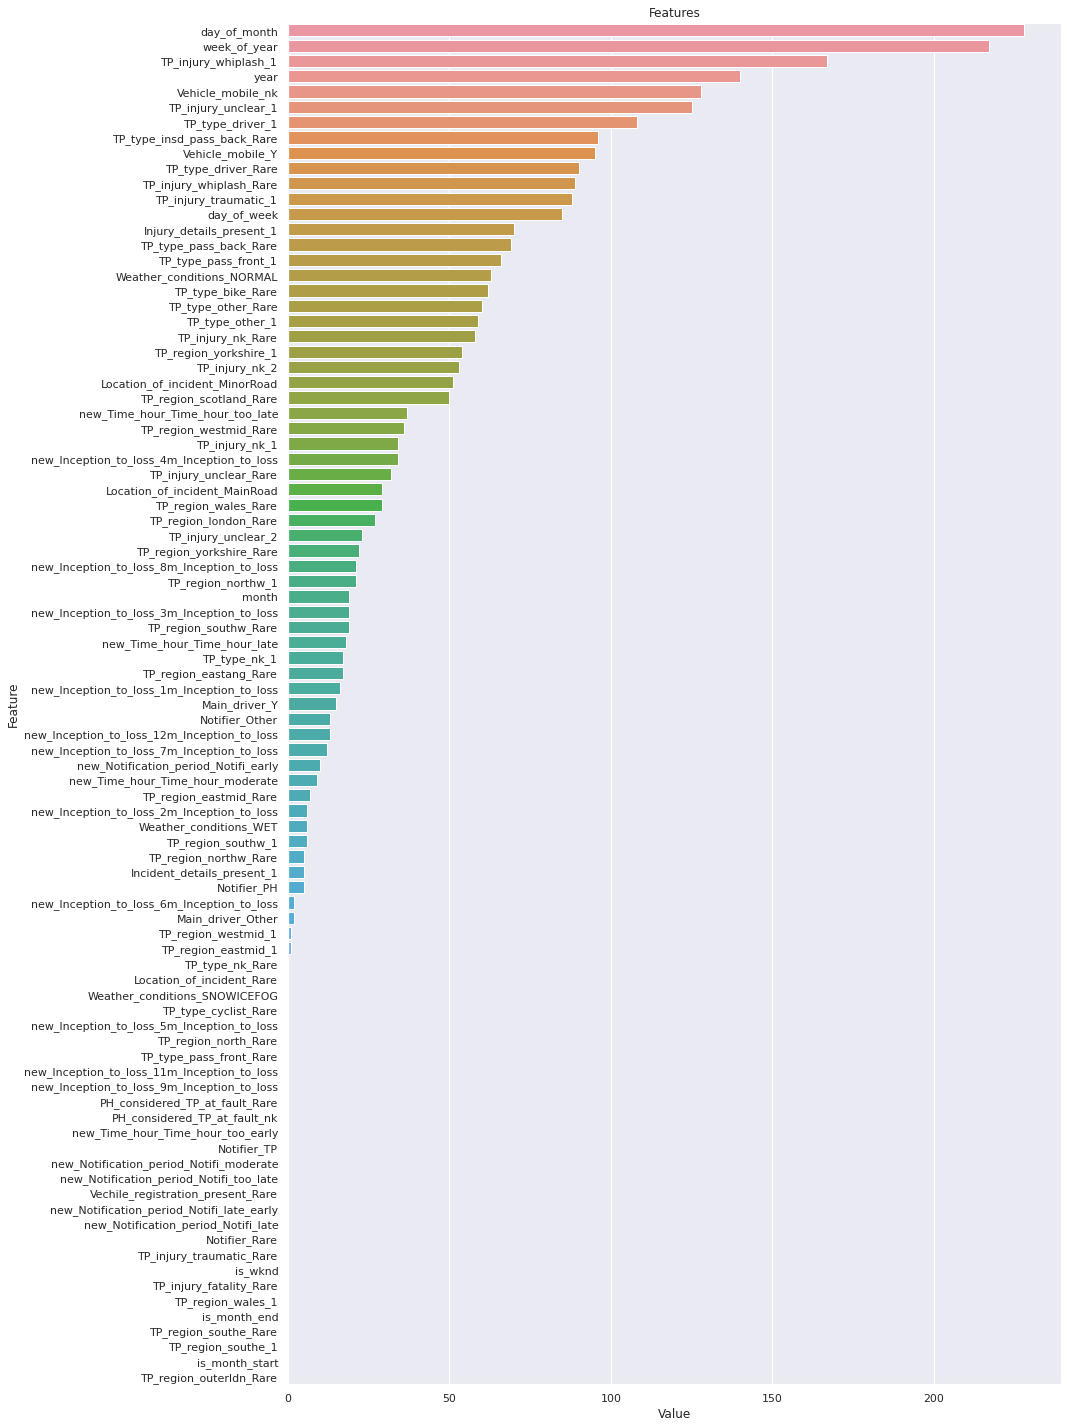

In [58]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(15, 20))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

  
plot_importance(lgbm_tuned, X_train)

## **Random Forest**

In [59]:
rf_model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

In [60]:
# test hatası
y_pred = rf_model.predict(X_test)
mean_absolute_error(y_test, y_pred),np.sqrt(mean_squared_error(y_test, y_pred))

(3244.8024086223054, 4496.141776641523)

### **Model Tuning**

In [61]:
rf_params = {"max_depth": [5, 8, None],
             "max_features": [3, 5, 15],
             "n_estimators": [200, 500],
             "min_samples_split": [2, 5, 8, 10]}

rf_model = RandomForestRegressor(random_state=42)
rf_cv_model = GridSearchCV(rf_model, rf_params, cv=5, n_jobs=-1, verbose=1).fit(X_train, y_train)


Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [62]:
rf_tuned = RandomForestRegressor(**rf_cv_model.best_params_).fit(X_train, y_train)
y_pred = rf_tuned.predict(X_test)
mean_absolute_error(y_test, y_pred),np.sqrt(mean_squared_error(y_test, y_pred))

(3152.3434998696844, 4362.998297245356)

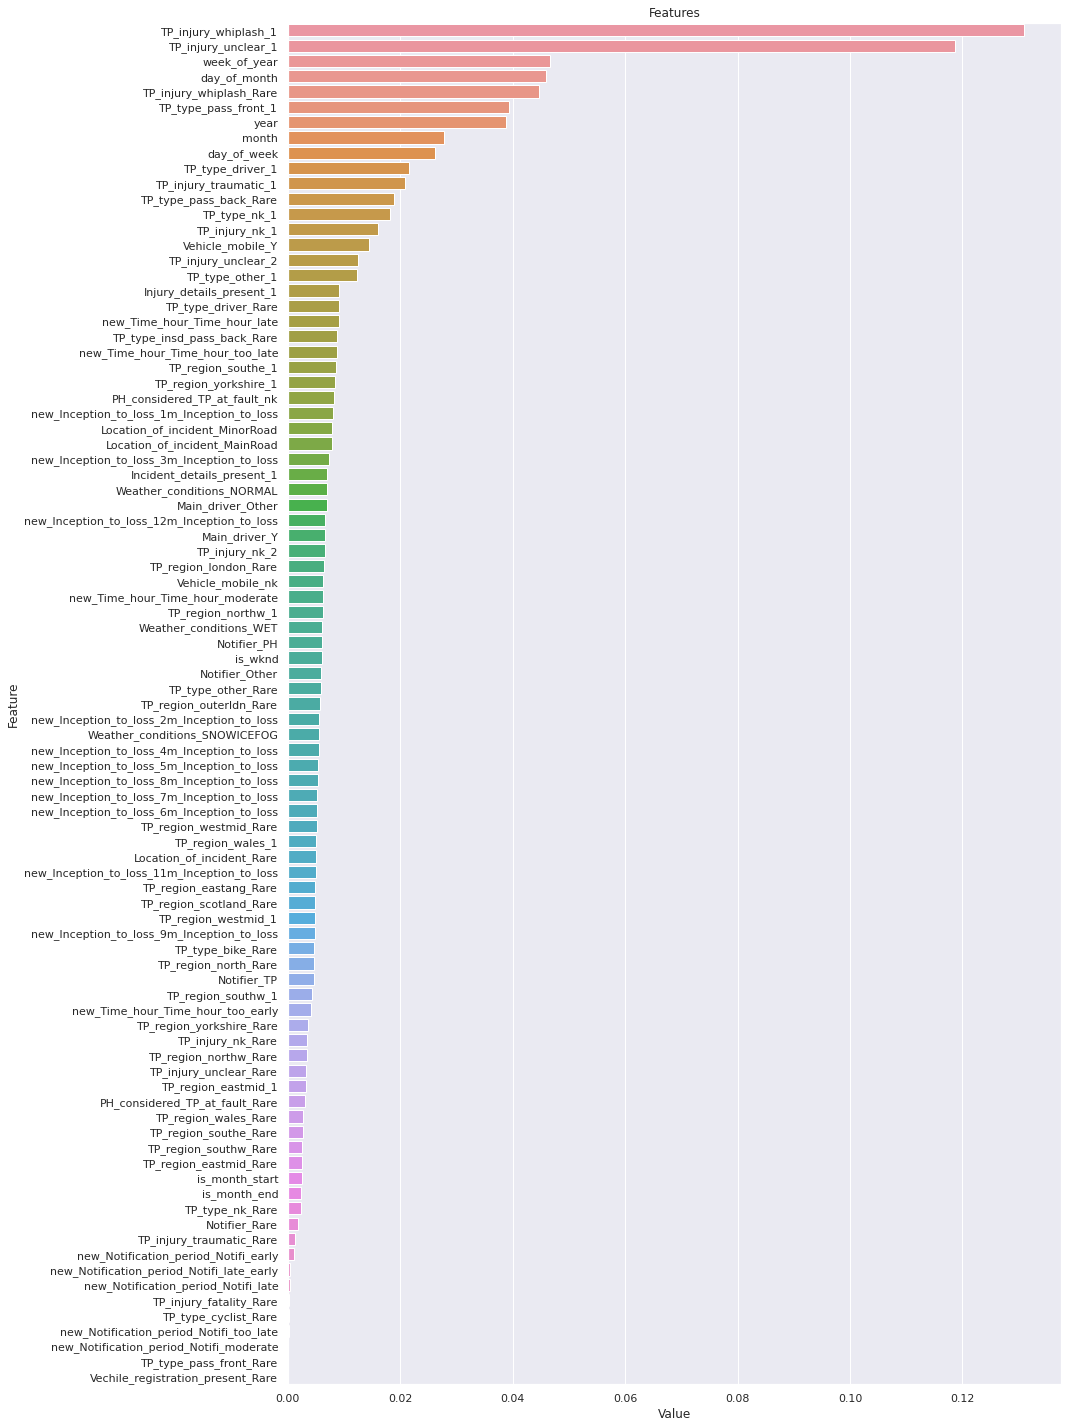

In [63]:
plot_importance(rf_tuned, X_train)